### Обучение на NewsAggrregatorKaggleFN
Тестирование на Fake and real news dataset

In [ ]:
import tensorflow as tf
import os
import numpy as np
import random

SEED = 42

In [ ]:
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [ ]:
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 110.8 MB/s eta 0:00:00


In [ ]:
import re
import nltk
import pandas as pd
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

from transformers import BertTokenizer
from sklearn.metrics import roc_curve, confusion_matrix,auc, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
news_data = pd.read_csv('/content/drive/MyDrive/Data/NewsAgreggatorKaggleFNforBERT.csv')
news_data.head()

,title,label
0,supply demand chain executive oil falls to aro...,0
1,london south east major averages climb off low...,0
2,gabrielle cintorino new poll shows support for...,1
3,artist s impression of the clinton machine rus...,1
4,worcester telegram s p gains on global growth ...,0


In [ ]:
print(news_data['title'])

0        supply demand chain executive oil falls to aro...
1        london south east major averages climb off low...
2        gabrielle cintorino new poll shows support for...
3        artist s impression of the clinton machine rus...
4        worcester telegram s p gains on global growth ...
                               ...                        
24633    qfinance com global markets world stocks coppe...
24634    david gutierrez staff writer why hydrogen pero...
24635    bay news spacex preps falcon rocket for pre da...
24636    law subscription jos a bank men s wearhouse in...
24637    hillary clinton laundered isis cash says inves...
Name: title, Length: 24638, dtype: object


In [ ]:
news_data.isnull().sum()

title    180
label      0
dtype: int64

In [ ]:
news_data = news_data.dropna()

In [ ]:
news_data.isnull().sum()

title    0
label    0
dtype: int64

In [ ]:
#separating the data and label
X = news_data['title'].values
Y = news_data['label'].values

In [ ]:
print(X)

['supply demand chain executive oil falls to around after china japan data'
 'london south east major averages climb off lows but remain in the red'
 'gabrielle cintorino new poll shows support for police officers is on the rise cop haters will be furious'
 ... 'bay news spacex preps falcon rocket for pre dawn launch sunday'
 'law subscription jos a bank men s wearhouse ink b merger deal'
 'hillary clinton laundered isis cash says investigating u s army officer']


In [ ]:
print(Y)

[0 0 1 ... 0 0 1]


In [ ]:
EPOCHS=2
max_seq_length = 60
LEARNING_RATE=1e-5
early_stopping=early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
def bert_encode(data, max_len) :
    input_ids = [] 
    attention_masks = []
    
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=max_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
# # First load the real tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

### Fine-tuning Model

In [ ]:
from transformers import TFBertModel

In [ ]:
bert_layers = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

train_input_ids, train_attention_masks = bert_encode(X_train, 60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
def build_model(transformer_layer,max_len=max_seq_length):
    input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32',name='attention_masks')

    output = bert_layers([input_ids,attention_masks])
    output = output[1]
    net = tf.keras.layers.Dense(32,activation='relu')(output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(1,activation='sigmoid')(net)
    outputs = net
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = outputs)
    
    
    return model

In [ ]:
def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('BERT')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc')]

In [ ]:
model = build_model(bert_layers, max_len=max_seq_length)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=METRICS)

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    Y_train,
    validation_split=0.2, 
    epochs=2,
    batch_size=32)

Epoch 1/2
490/490 [==============================] - 283s 466ms/step - loss: 0.1780 - tp: 7180.0000 - fp: 562.0000 - tn: 7315.0000 - fn: 595.0000 - accuracy: 0.9261 - precision: 0.9274 - recall: 0.9235 - auc: 0.9810 - val_loss: 0.0626 - val_tp: 1872.0000 - val_fp: 23.0000 - val_tn: 1955.0000 - val_fn: 64.0000 - val_accuracy: 0.9778 - val_precision: 0.9879 - val_recall: 0.9669 - val_auc: 0.9977
Epoch 2/2
490/490 [==============================] - 210s 428ms/step - loss: 0.0440 - tp: 7658.0000 - fp: 105.0000 - tn: 7772.0000 - fn: 117.0000 - accuracy: 0.9858 - precision: 0.9865 - recall: 0.9850 - auc: 0.9983 - val_loss: 0.0843 - val_tp: 1852.0000 - val_fp: 8.0000 - val_tn: 1970.0000 - val_fn: 84.0000 - val_accuracy: 0.9765 - val_precision: 0.9957 - val_recall: 0.9566 - val_auc: 0.9954


In [ ]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [ ]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 21s 137ms/step - loss: 0.0809 - tp: 2310.0000 - fp: 12.0000 - tn: 2452.0000 - fn: 118.0000 - accuracy: 0.9734 - precision: 0.9948 - recall: 0.9514 - auc: 0.9960


In [ ]:
print(f'BERT accuracy: {score[5]}')

BERT accuracy: 0.9734259843826294


In [ ]:
y_predict_prob=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 23s 135ms/step


In [ ]:
print(classification_report(Y_test,  np.round(y_predict_prob)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2464
           1       0.99      0.95      0.97      2428

    accuracy                           0.97      4892
   macro avg       0.97      0.97      0.97      4892
weighted avg       0.97      0.97      0.97      4892



In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
print('BERT: ROC AUC=%.4f' % roc_auc_score(Y_test, y_predict_prob))

BERT: ROC AUC=0.9987


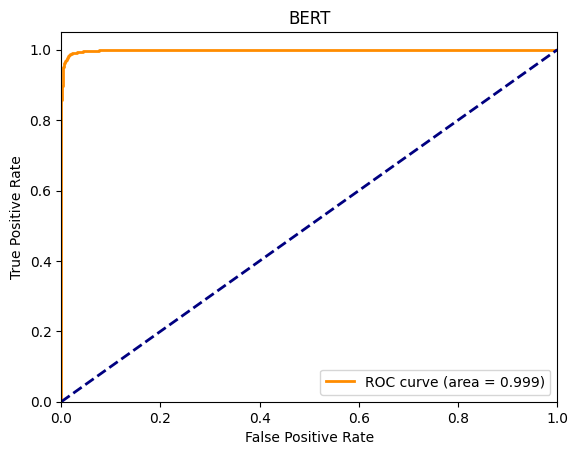

In [ ]:
fpr, tpr, _ = roc_curve(Y_test, y_predict_prob)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)

**Testing: Fake and real news dataset**

In [ ]:
news_test = pd.read_csv('/content/drive/MyDrive/Data/FNDatasetBERT.csv')

In [ ]:
x_test = news_test['title'].values
y_test = news_test['label'].values

In [ ]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 192s 137ms/step - loss: 0.5045 - tp: 21303.0000 - fp: 4028.0000 - tn: 17389.0000 - fn: 2178.0000 - accuracy: 0.8618 - precision: 0.8410 - recall: 0.9072 - auc: 0.9264


In [ ]:
print(f'BERT accuracy FNDataset: {score[5]}')

BERT accuracy FNDataset: 0.8617755770683289


In [ ]:
model.save('/content/drive/MyDrive/Models/FINAL/BERT.h5')

### Training Classifier

In [ ]:
bert_layers = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = build_model(bert_layers, max_len=max_seq_length)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=METRICS)

In [ ]:
model.layers[2].trainable = False

In [ ]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 60)]         0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                          

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    Y_train,
    validation_split=0.2, 
    epochs=2,
    batch_size=32)

Epoch 1/2
490/490 [==============================] - 263s 426ms/step - loss: 0.1874 - tp: 28486.0000 - fp: 4550.0000 - tn: 24744.0000 - fn: 2770.0000 - accuracy: 0.8791 - precision: 0.8623 - recall: 0.9114 - auc: 0.9308 - val_loss: 0.0631 - val_tp: 1911.0000 - val_fp: 64.0000 - val_tn: 1914.0000 - val_fn: 25.0000 - val_accuracy: 0.9773 - val_precision: 0.9676 - val_recall: 0.9871 - val_auc: 0.9979
Epoch 2/2
490/490 [==============================] - 201s 411ms/step - loss: 0.0467 - tp: 7660.0000 - fp: 98.0000 - tn: 7779.0000 - fn: 115.0000 - accuracy: 0.9864 - precision: 0.9874 - recall: 0.9852 - auc: 0.9974 - val_loss: 0.0521 - val_tp: 1882.0000 - val_fp: 13.0000 - val_tn: 1965.0000 - val_fn: 54.0000 - val_accuracy: 0.9829 - val_precision: 0.9931 - val_recall: 0.9721 - val_auc: 0.9983


In [ ]:
test_input_ids, test_attention_masks = bert_encode(X_test, 60)

In [ ]:
score = model.evaluate([test_input_ids, test_attention_masks], Y_test, verbose=1) 

153/153 [==============================] - 20s 133ms/step - loss: 0.0512 - tp: 2366.0000 - fp: 21.0000 - tn: 2443.0000 - fn: 62.0000 - accuracy: 0.9830 - precision: 0.9912 - recall: 0.9745 - auc: 0.9984


In [ ]:
print(f'BERT accuracy: {score[5]}')

BERT accuracy: 0.9830335378646851


In [ ]:
y_predict_prob=model.predict([test_input_ids, test_attention_masks], verbose=1)

153/153 [==============================] - 23s 132ms/step


In [ ]:
print(classification_report(Y_test,  np.round(y_predict_prob)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2464
           1       0.99      0.97      0.98      2428

    accuracy                           0.98      4892
   macro avg       0.98      0.98      0.98      4892
weighted avg       0.98      0.98      0.98      4892



In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
print('BERT: ROC AUC=%.4f' % roc_auc_score(Y_test, y_predict_prob))

BERT: ROC AUC=0.9987


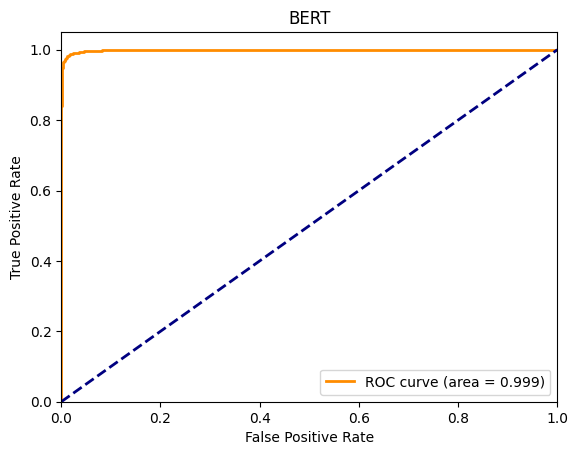

In [ ]:
fpr, tpr, _ = roc_curve(Y_test, y_predict_prob)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)

**Testing: Fake and real news dataset**

In [ ]:
test_input_ids, test_attention_masks = bert_encode(x_test, 60)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
score = model.evaluate([test_input_ids, test_attention_masks], y_test, verbose=1) 

1404/1404 [==============================] - 189s 134ms/step - loss: 0.5317 - tp: 22580.0000 - fp: 5688.0000 - tn: 15729.0000 - fn: 901.0000 - accuracy: 0.8532 - precision: 0.7988 - recall: 0.9616 - auc: 0.9407


In [ ]:
print(f'BERT accuracy FNDataset: {score[5]}')

BERT accuracy FNDataset: 0.8532451391220093


In [ ]:
model.save('/content/drive/MyDrive/Models/FINAL/BERT_freezed.h5')